In [1]:
from pathlib import Path
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run import start_run
from neuralhydrology.utils.config import Config

from tqdm import tqdm
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd
from neuralhydrology.datasetzoo import hourlycamelsus

In [2]:


from pathlib import Path
import xarray as xr

data_dir = Path("F:\Data\LSH\CAMUS_TO")
camus_nc = data_dir / "camusto_1h.nc"

with xr.open_dataset(camus_nc) as camus:
    camus = camus.rename({"datetime": "date","station":"basin"})
    basins_with_qobs_camus = camus.basin[~camus["discharge(cms)"].isnull().all(axis=0)].values.tolist()

basins_with_qobs_camus = [f"{b:0>8}" for b in basins_with_qobs_camus]

with open("camus_basins.txt", "w") as file:
    file.write("\n".join(basins_with_qobs_camus))





In [3]:
import xarray as xr


with xr.open_dataset(camus_nc) as camus:
    camus = camus.rename({"datetime": "date","station":"basin"})
    discharge_counts = (len(camus.date) - camus["discharge(cms)"].isnull().sum(axis=0)).values

In [4]:

highest_basin = np.argmax(discharge_counts)
camus.basin.values[highest_basin]

'HY006'

In [19]:
data_dir = Path("F:\Data\LSH\CAMELS_US")

camels_toronto_nc = data_dir / "hourly" / "usgs-streamflow-nldas_hourly.nc"
with xr.open_dataset(camels_toronto_nc) as ds:
    basins_with_qobs_camels = ds.basin.values.tolist()
len(basins_with_qobs_camels)

516

In [6]:

attribute_tables = []
data_dir = Path("F:\Data\LSH\CAMELS_US")

for attribute_group in ["hydro", "topo","clim","soil","vege"]:
    attribute_tables.append(pd.read_csv(data_dir / "camels_attributes_v2.0" / f"camels_{attribute_group}.txt", delimiter=";", index_col=0))
camels_attributes = pd.concat(attribute_tables, axis=1)
camels_attributes.index = camels_attributes.index.astype(str)
attribute_tables = []
data_dir = Path("F:\Data\LSH\CAMUS_TO")
for attribute_group in ["hydromet","landuse","topo"]:
    attribute_tables.append(pd.read_csv(data_dir / "attributes" / f"attributes_{attribute_group}.csv", delimiter=",", index_col=0))
camus_attributes = pd.concat(attribute_tables, axis=1)


In [9]:
merged_attributes = pd.concat([camus_attributes, camels_attributes])
common_attributes = list(set(camus_attributes.columns).intersection(set(camels_attributes.columns)))

merged_attributes = merged_attributes[common_attributes]

data_dir = Path("F:\Data\LSH\CAMELS_US_TORONTO")
merged_attributes.index.name = "gauge_id"
merged_attributes.index = merged_attributes.index.map(lambda x: f"{x:0>8}")

merged_attributes.to_csv(data_dir / "camels_attributes_v2.0" / "camels_merged.txt", sep=";", index=True)

merged_attributes


,low_prec_freq,gauge_lon,q95,aridity,high_prec_dur,high_prec_freq,gauge_lat,p_mean,pet_mean,q5,...,frac_snow,p_seasonality,q_mean,high_q_dur,high_q_freq,low_prec_dur,zero_q_freq,elev_mean,runoff_ratio,frac_forest
gauge_id,,,,,,,,,,,,,,,,,,,,,
000HY018,0.001948,-79.39100,2.252980,0.065904,1.093750,0.000163,43.74000,2.162123,4.325017,0.333115,...,0.124585,0.096422,1.165333,1.666667,0.000003,3.888742,0.000000,211.96796,0.134713,0.049739
000HY017,0.001925,-79.47200,1.631879,0.064578,1.096774,0.000158,43.79300,2.185669,4.284087,0.154744,...,0.135141,0.096622,1.403528,1.000000,0.000003,3.777344,0.000000,227.93353,0.271323,0.029946
000HY006,0.001888,-79.73600,4.793319,0.058234,1.141463,0.000155,43.88200,2.310380,4.083609,1.009396,...,0.177423,0.099572,2.284444,1.000000,0.000002,3.686528,0.000000,335.87662,0.110440,0.334921
000HY034,0.001935,-79.23100,0.070603,0.065117,1.092166,0.000157,43.79800,2.175894,4.300572,0.036429,...,0.118579,0.095867,0.048930,1.130435,0.000017,3.831800,0.000000,179.06764,0.038945,0.010374
000HY035,0.001902,-79.70500,2.061397,0.062822,1.111628,0.000159,43.76800,2.238192,4.267750,0.038839,...,0.149300,0.098891,0.504640,1.550000,0.000021,3.742820,0.000000,258.72415,0.112151,0.072493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14309500,222.650000,-123.61091,10.203129,0.627228,1.776471,15.100000,42.80400,4.977781,3.122204,0.057651,...,0.061255,-0.995847,2.457700,4.835294,41.100000,6.893189,0.000000,709.83000,0.493734,1.000000
14316700,214.850000,-122.72894,10.653569,0.501305,1.446078,14.750000,43.34984,4.543400,2.277630,0.141493,...,0.176337,-0.821172,2.925937,2.543307,16.150000,6.018207,0.000000,952.26000,0.643997,1.000000
14325000,219.050000,-124.07065,15.891946,0.386610,1.467337,14.600000,42.89150,6.297437,2.434652,0.104916,...,0.030203,-0.952055,4.072283,3.216216,23.800000,6.240741,0.000000,656.53000,0.646657,1.000000


In [10]:
[basin for basin in merged_attributes.index if basin.startswith('0000HY')]

[]

In [36]:
merged_attributes

,low_prec_freq,gauge_lon,q95,aridity,high_prec_dur,high_prec_freq,gauge_lat,p_mean,pet_mean,q5,...,p_seasonality,q_mean,high_q_dur,high_q_freq,low_prec_dur,zero_q_freq,elev_mean,runoff_ratio,frac_forest,Cluster
gauge_id,,,,,,,,,,,,,,,,,,,,,
000HY018,0.001948,-79.39100,2.252980,0.065904,1.093750,0.000163,43.74000,2.162123,4.325017,0.333115,...,0.096422,1.165333,1.666667,0.000003,3.888742,0.000000,211.96796,0.134713,0.049739,0.0
000HY017,0.001925,-79.47200,1.631879,0.064578,1.096774,0.000158,43.79300,2.185669,4.284087,0.154744,...,0.096622,1.403528,1.000000,0.000003,3.777344,0.000000,227.93353,0.271323,0.029946,0.0
000HY006,0.001888,-79.73600,4.793319,0.058234,1.141463,0.000155,43.88200,2.310380,4.083609,1.009396,...,0.099572,2.284444,1.000000,0.000002,3.686528,0.000000,335.87662,0.110440,0.334921,0.0
000HY034,0.001935,-79.23100,0.070603,0.065117,1.092166,0.000157,43.79800,2.175894,4.300572,0.036429,...,0.095867,0.048930,1.130435,0.000017,3.831800,0.000000,179.06764,0.038945,0.010374,0.0
000HY035,0.001902,-79.70500,2.061397,0.062822,1.111628,0.000159,43.76800,2.238192,4.267750,0.038839,...,0.098891,0.504640,1.550000,0.000021,3.742820,0.000000,258.72415,0.112151,0.072493,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14309500,222.650000,-123.61091,10.203129,0.627228,1.776471,15.100000,42.80400,4.977781,3.122204,0.057651,...,-0.995847,2.457700,4.835294,41.100000,6.893189,0.000000,709.83000,0.493734,1.000000,1.0
14316700,214.850000,-122.72894,10.653569,0.501305,1.446078,14.750000,43.34984,4.543400,2.277630,0.141493,...,-0.821172,2.925937,2.543307,16.150000,6.018207,0.000000,952.26000,0.643997,1.000000,1.0
14325000,219.050000,-124.07065,15.891946,0.386610,1.467337,14.600000,42.89150,6.297437,2.434652,0.104916,...,-0.952055,4.072283,3.216216,23.800000,6.240741,0.000000,656.53000,0.646657,1.000000,1.0


In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os
os.environ["OMP_NUM_THREADS"] = "3"



camus_basins = [basin for basin in merged_attributes.index if basin.startswith("000HY")]
#basins_with_qobs_camels = [basin for basin in merged_attributes.index if ~basin.startswith("0000HY")]

camus_basins = [basin for basin in camus_basins if not merged_attributes.loc[basin].isnull().any()]

# Select numeric columns for clustering
numeric_columns = merged_attributes.loc[:,:].select_dtypes(include=['float64']).columns
data_for_clustering = merged_attributes.loc[basins_with_qobs_camels + camus_basins, numeric_columns].dropna()
from neuralhydrology.datautils.clusterutils import cluster_basin_attributes

basins, cluster_results = cluster_basin_attributes(data_for_clustering, n=48, k=4, random_state=1, required_basins=camus_basins)

output_path = f"cc_{len(basins)}.txt"
with open(output_path, "w") as file:
    file.write("\n".join(basins))

Cluster
0    233
3    150
2    104
1     67
Name: count, dtype: int64
True
48
48
48
10


c:\Users\everett\.conda\envs\neuralhydrology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [46]:
len(basins)

192

In [44]:
len(camus_basins)

38

In [34]:
len([basin for basin in camus_basins if basin in data_for_clustering.index.to_list()])

38

In [ ]:
kebn

['000HY018',
 '000HY017',
 '000HY006',
 '000HY034',
 '000HY035',
 '000HY024',
 '000HY051',
 '000HY095',
 '000HY053',
 '000HY097',
 '000HY048',
 '000HY091',
 '000HY062',
 '000HY101',
 '000HY118',
 '000HY084',
 '000HY098',
 '000HY119',
 '000HY045',
 '000HY081',
 '000HY059',
 '000HY023',
 '000HY112',
 '000HY092',
 '000HY100',
 '000HY093',
 '000HY054',
 '000HY040',
 '000HY052',
 '000HY028',
 '000HY082',
 '000HY066',
 '000HY010',
 '000HY065',
 '000HY089',
 '000HY090',
 '000HY047',
 '000HY013',
 '000HY026',
 '000HY019',
 '000HY079',
 '000HY103',
 '000HY022',
 '000HY014',
 '000HY080',
 '000HY120',
 '000HY068',
 '000HY116',
 '000HY060',
 '000HY104',
 '000HY067',
 '000HY123',
 '000HY027',
 '000HY044',
 '000HY005']

In [11]:
output_path = f"{len(basins_with_qobs_camels)}-camels-basins.txt"

with open(output_path, "w") as file:
    file.write("\n".join(basins_with_qobs_camels))

In [ ]:
output_path = "static_attributes.txt"

with open(output_path, "w") as file:
    file.write("\n".join(common_attributes))

basins_with_qobs = basins_with_qobs_camels + basins_with_qobs_camus

#merged_attributes = pd.read_csv(data_dir / "camels_attributes_v2.0" / "camels_merged.txt", sep=";", index_col=0)

basin_list_static = merged_attributes.index[~merged_attributes.isna().any(axis=1)].to_list()

basin_list = list(set(basins_with_qobs).intersection(set(basin_list_static)))

output_path = f"{len(basin_list)}_basin_list.txt"
with open(output_path, "w") as file:
    file.write("\n".join(basin_list))

output_path = "trca_basins.txt"
with open(output_path, "w") as file:
    file.write("\n".join(camus_basins))


In [15]:
output_path

'trca_basins.txt'

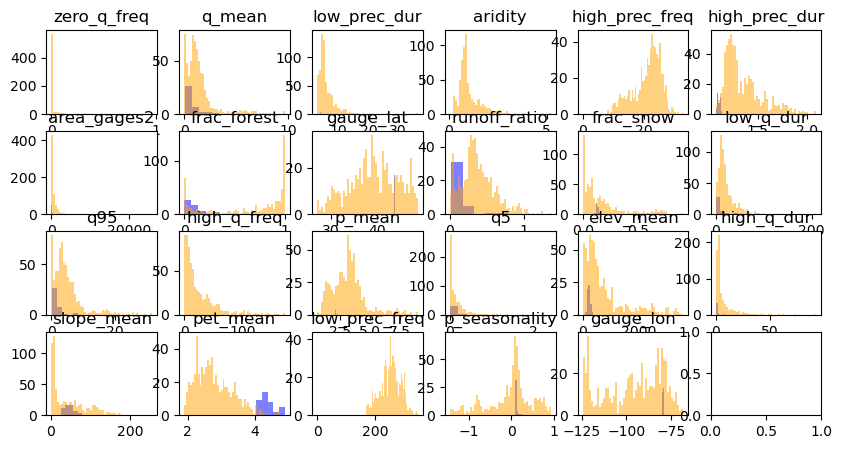

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(10, 5))
for attribute in common_attributes:
    ax = axs.flatten()[common_attributes.index(attribute)]
    camus_attributes[attribute].plot.hist(ax=ax, label="CAMUS_TO", bins=5, color="blue", alpha=0.5)
    camels_attributes[attribute].plot.hist(ax=ax, label="CAMELS_US", bins=50, color="orange", alpha=0.5)
    ax.set_title(attribute)
    ax.set_ylabel("")

In [12]:
camels_toronto_nc = data_dir / "hourly" / "usgs-streamflow-nldas_hourly.nc"
with xr.open_dataset(camels_toronto_nc) as ds:
    basin_list_forcing = ds.basin.values.tolist()


In [13]:
data_dir = Path("F:\Data\LSH\CAMELS_US")
camels_nc = data_dir / "hourly" / "usgs-streamflow-nldas_hourly.nc"

import xarray as xr
with xr.open_dataset(camels_nc) as camels:
    camels_basin_ids = camels.basin.values
    print(camels.data_vars)

Data variables:
    convective_fraction        (basin, date) float32 ...
    longwave_radiation         (basin, date) float32 ...
    potential_energy           (basin, date) float32 ...
    potential_evaporation      (basin, date) float32 ...
    pressure                   (basin, date) float32 ...
    shortwave_radiation        (basin, date) float32 ...
    specific_humidity          (basin, date) float32 ...
    temperature                (basin, date) float32 ...
    total_precipitation        (basin, date) float32 ...
    wind_u                     (basin, date) float32 ...
    wind_v                     (basin, date) float32 ...
    qobs_mm_per_hour           (basin, date) float32 ...
    qobs_count                 (basin, date) float32 ...
    qualifiers                 (basin, date) object ...
    utcoffset_hours            (basin, date) float32 ...
    rel_deviation_from_camels  (basin, date) float32 ...
    qobs_CAMELS_mm_per_hour    (basin, date) float32 ...


In [14]:
data_dir = Path("F:\Data\LSH\CAMELS_US")
camels_nc = data_dir / "hourly" / "usgs-streamflow-nldas_hourly.nc"

import xarray as xr
with xr.open_dataset(camels_nc) as camels:
    camels_basin_ids = camels.basin.values
    camels_vars = list(camels.data_vars)

    data_dir = Path("F:\Data\LSH\CAMUS_TO")
    camus_nc = data_dir / "camusto_1h.nc"

    with xr.open_dataset(camus_nc) as camus:
        camus = camus.rename({"datetime": "date","station":"basin"})
        camus_vars = list(camus.data_vars)
        camus = camus.rename({
            "discharge(mm)": "qobs_mm_per_hour",
            "precipitation(mm)": "total_precipitation",
            "temperature(C)": "temperature",
            "stn_press(kPa)":"pressure"})
        
        camus_basins_with_forcing = camus.basin.values[]
        
        common_forcing_vars = list(set(camus.data_vars).intersection(set(camels.data_vars)))
        camels = camels[common_forcing_vars]
        camus = camus[common_forcing_vars]
        
        camels = camels.assign_coords(basin=camels.basin.astype(str))
        #camels = camels.assign_coords(basin=camels.basin.astype('U8'))

        print(camels)
        camus = camus.astype('float32')

        # Create a new dataset for the new basin
count = 0

for basin in tqdm(camus.basin.values):
    basin_str = f"{basin:0>8}"  # Convert basin to an 8-digit string with leading zeros
    new_basin_data = xr.Dataset(
        {
            "qobs_mm_per_hour": (["date"], camus.qobs_mm_per_hour.sel(basin=basin).values),
            "temperature": (["date"],  camus.temperature.sel(basin=basin).values),
            "total_precipitation": (["date"],  camus.total_precipitation.sel(basin=basin).values),
            "pressure": (["date"],  camus.pressure.sel(basin=basin).values) * 1000,
        },
        coords={
            "date": camus.date.values,
            "basin": basin_str
        }
    )

    # Add the new basin to camels1
    if count == 0:
        aggregated_basin_data = new_basin_data
    else:
        aggregated_basin_data = xr.concat([aggregated_basin_data, new_basin_data], dim="basin")
    count += 1

    

SyntaxError: invalid syntax (482687813.py, line 21)

In [ ]:
data_dir = Path("F:\Data\LSH\CAMELS_US")
camels_nc = data_dir / "hourly" / "usgs-streamflow-nldas_hourly.nc"

import xarray as xr
with xr.open_dataset(camels_nc) as camels:
    camels2000 = camels.sel(date=slice("2000-01-01", None))
    camels2000 = camels2000[common_forcing_vars]
    hourly_index = pd.date_range(start="2000-01-01", end="2024-12-31 23:00:00", freq="H")
    camels_merged = xr.concat([camels2000, aggregated_basin_data], dim=hourly_index)
    camels_merged.to_netcdf(Path("F:\Data\LSH\CAMELS_US_TORONTO\camels_toronto.nc"))

C:\Users\everett\AppData\Local\Temp\ipykernel_7440\2573738383.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start="2000-01-01", end="2024-12-31 23:00:00", freq="H")


In [ ]:
import xarray as xr
with xr.open_dataset("F:\Data\LSH\CAMELS_US_TORONTO\camels_toronto.nc") as camels:
    print(camels)
    df = camels.sel(basin="000HY014").to_dataframe()

<xarray.Dataset>
Dimensions:              (basin: 571, date: 389582)
Coordinates:
  * basin                (basin) object '000HY005' '000HY006' ... '14400000'
  * date                 (date) datetime64[ns] 2000-01-01 ... 2025-03-30
Data variables:
    total_precipitation  (basin, date) float32 ...
    qobs_mm_per_hour     (basin, date) float32 ...
    temperature          (basin, date) float32 ...
    pressure             (basin, date) float32 ...


In [ ]:
len(hourly_index)

C:\Users\everett\AppData\Local\Temp\ipykernel_7440\2800628966.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start="2000-01-01", end="2024-12-31 23:00:00", freq="H")


219168

<Axes: xlabel='date'>

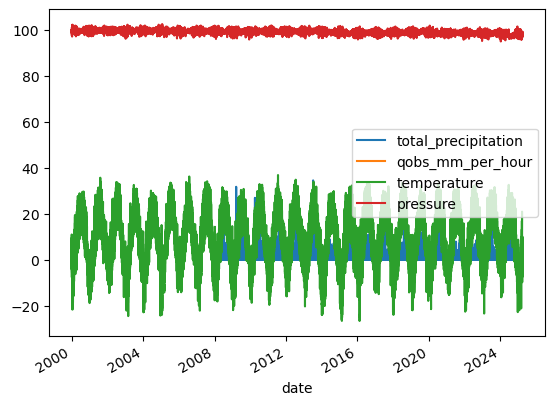

In [ ]:
print(aggregated_basin_data)

<xarray.Dataset>
Dimensions:              (basin: 55, date: 221281)
Coordinates:
  * date                 (date) datetime64[ns] 2000-01-01 ... 2025-03-30
  * basin                (basin) <U5 'HY018' 'HY017' 'HY006' ... 'HY005' 'HY013'
Data variables:
    qobs_mm_per_hour     (basin, date) float32 nan nan nan nan ... nan nan nan
    temperature          (basin, date) float32 0.9465 0.9741 1.16 ... -0.2 -0.3
    total_precipitation  (basin, date) float32 nan nan nan nan ... 1.3 3.1 2.0
    pressure             (basin, date) float32 100.3 100.3 100.3 ... 98.76 98.7


In [ ]:

import xarray as xr
with xr.open_dataset(camels_nc) as camels:
    camels1 = camels.sel(basin=camels.basin.values[0])

In [ ]:
data_dir = Path("F:\Data\LSH\CAMELS_US_TORONTO")
camels_nc = data_dir / "hourly" / "usgs-streamflow-nldas_hourly.nc"

import xarray as xr
with xr.open_dataset(camels_nc) as camels:
    print(camels)


<xarray.Dataset>
Dimensions:              (date: 405348, basin: 571)
Coordinates:
  * date                 (date) datetime64[ns] 1979-01-01T13:00:00 ... 2025-0...
  * basin                (basin) object '08196' '01580' ... 'HY005' 'HY013'
Data variables:
    total_precipitation  (basin, date) float32 ...
    pressure             (basin, date) float32 ...
    qobs_mm_per_hour     (basin, date) float32 ...
    temperature          (basin, date) float32 ...


Text(0.5, 1.0, 'Test period - daily NSE 0.607')

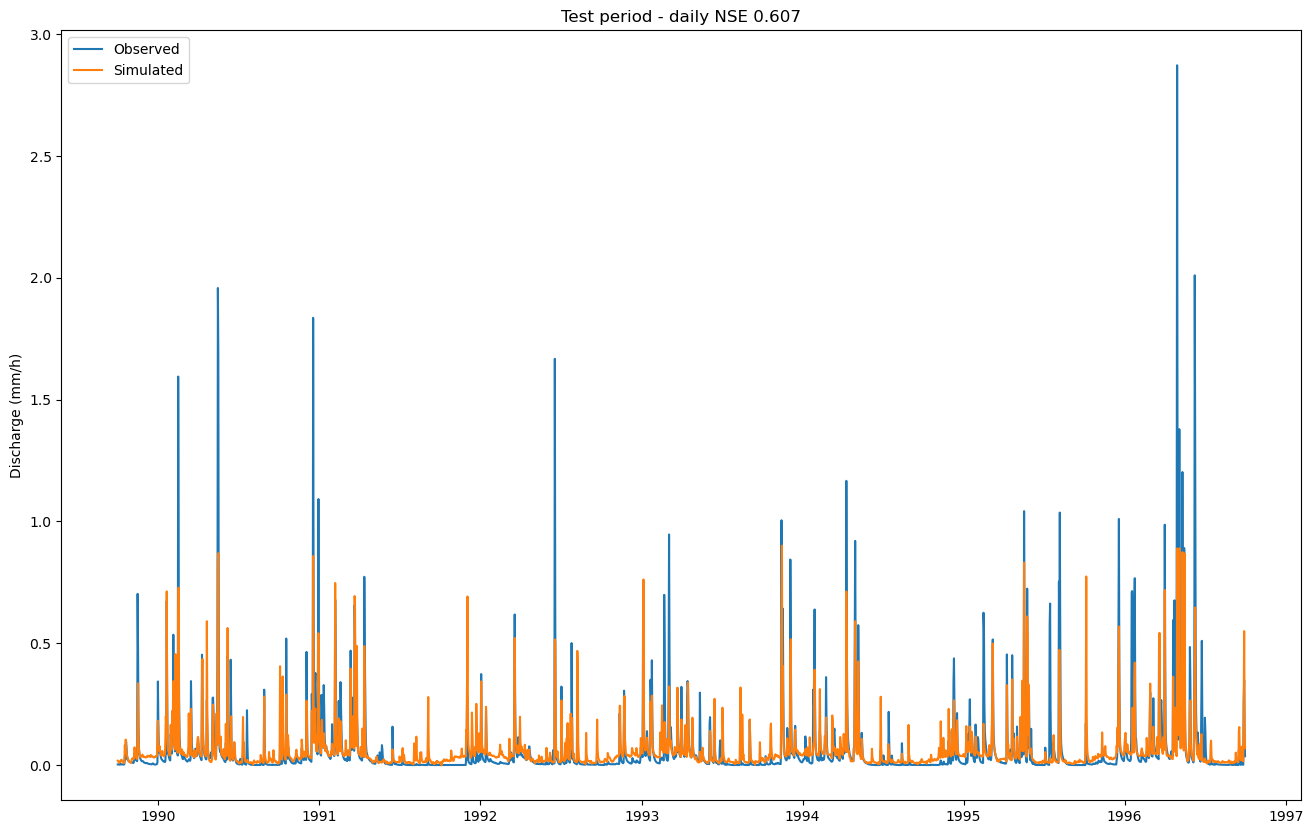

In [ ]:
# extract observations and simulations
daily_qobs = results["03291780"]["1D"]["xr"]["QObs_CAMELS(mm/h)_obs"]
daily_qsim = results["03291780"]["1D"]["xr"]["QObs_CAMELS(mm/h)_sim"]

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(daily_qobs["date"], daily_qobs, label="Observed")
ax.plot(daily_qsim["date"], daily_qsim, label="Simulated")
ax.legend()
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - daily NSE {results['03291780']['1D']['NSE_1D']:.3f}")



...and finally, let's look more closely at the last few months' hourly predictions:

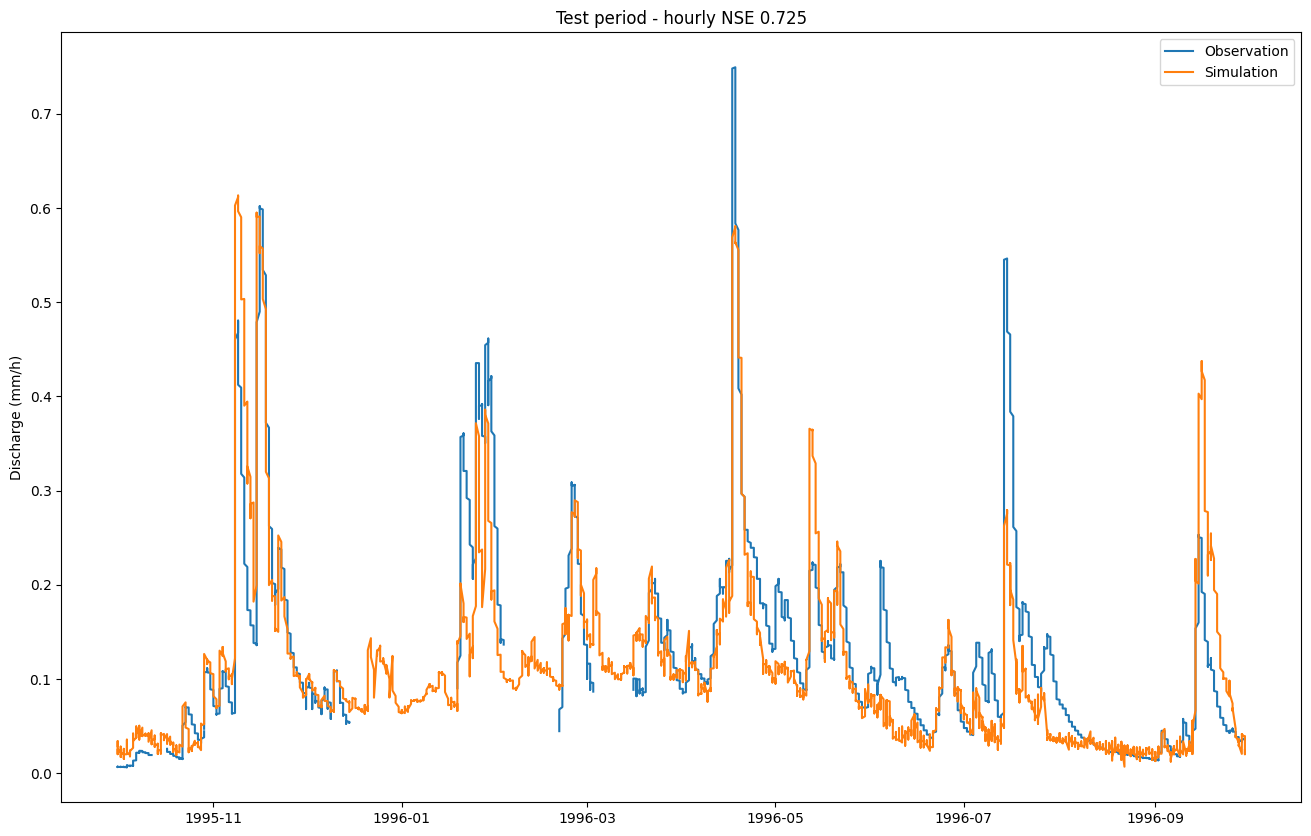

In [ ]:
# extract a date slice of observations and simulations
hourly_xr = results["01022500"]["1h"]["xr"].sel(date=slice("10-1995", None))

# The hourly data is indexed with two indices: The date (in days) and the time_step (the hour within that day).
# As we want to get a continuous plot of several days' hours, we select all 24 hours of each day and then stack
# the two dimensions into one consecutive datetime dimension.
hourly_xr = hourly_xr.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
hourly_xr['datetime'] = hourly_xr.coords['date'] + hourly_xr.coords['time_step']

hourly_qobs = hourly_xr["qobs_mm_per_hour_obs"]
hourly_qsim = hourly_xr["qobs_mm_per_hour_sim"]

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(hourly_qobs["datetime"], hourly_qobs, label="Observation")
ax.plot(hourly_qsim["datetime"], hourly_qsim, label="Simulation")
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - hourly NSE {results['01022500']['1h']['NSE_1h']:.3f}")
_ = ax.legend()